In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install -q -U tensorflow-addons

     |████████████████████████████████| 706kB 8.7MB/s 


In [ ]:
import tensorflow as tf
import cv2, skimage
from skimage import transform
import os
import time
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import sys
import warnings

warnings.filterwarnings('ignore')

In [ ]:
sys.path.append('/content/drive/MyDrive/B.Tech Project/codes')

In [ ]:
import models
from models import Generator3, Generator5, Discriminator
from utils import *

In [ ]:
!unzip '/content/drive/MyDrive/B.Tech Project/Datasets/dataset_1.zip'
!unzip '/content/drive/MyDrive/B.Tech Project/Datasets/sem7_test.zip'

Streaming output truncated to the last 5000 lines.
  inflating: dataset_1/train/00000291_(5).jpg  
  inflating: dataset_1/train/00000292.jpg  
  inflating: dataset_1/train/00000292_(2).jpg  
  inflating: dataset_1/train/00000292_(3).jpg  
  inflating: dataset_1/train/00000292_(4).jpg  
  inflating: dataset_1/train/00000292_(5).jpg  
  inflating: dataset_1/train/00000292_(6).jpg  
  inflating: dataset_1/train/00000293.jpg  
  inflating: dataset_1/train/00000293_(2).jpg  
  inflating: dataset_1/train/00000293_(3).jpg  
  inflating: dataset_1/train/00000293_(4).jpg  
  inflating: dataset_1/train/00000293_(5).jpg  
  inflating: dataset_1/train/00000293_(6).jpg  
  inflating: dataset_1/train/00000294.jpg  
  inflating: dataset_1/train/00000294_(2).jpg  
  inflating: dataset_1/train/00000294_(3).jpg  
  inflating: dataset_1/train/00000294_(4).jpg  
  inflating: dataset_1/train/00000294_(5).jpg  
 extracting: dataset_1/train/00000295.jpg  
  inflating: dataset_1/train/00000295_(2).jpg  
  inf

In [ ]:
PATH = '/content/dataset_1/'

In [ ]:
for f in os.listdir(PATH+'train/'):
    if not is_valid_image(PATH+'train/'+f,verbose=False):
        print(f)
        os.remove(PATH+'train/'+f)

for f in os.listdir(PATH+'test/'):
    if not is_valid_image(PATH+'test/'+f,verbose=False):
        print(f)
        os.remove(PATH+'test/'+f)

for f in os.listdir('/content/sem7_test/'):
    if not is_valid_image('/content/sem7_test/'+f,verbose=False):
        print(f)
        os.remove('/content/sem7_test/'+f)

desert-790640__340.webp
desert-65310__340.webp
desert-3291432__340.webp
tree-64310__340.jpg
barren-1838506__340.webp
roter-sand-2042738__340.jpg
lighthouse-5702233__340.jpg
desert-1654439__340.jpg
adventure-1850713__340.webp
namibia-2049206__340.webp
dunes-4461128__340.webp
sand-dunes-1245751__340.webp
gobi-692640__340.jpg
desert-2774945__340.jpg
desert-123978__340.jpg
baltic-sea-4095045__340.webp
dunes-4033821__340.webp
camels-1149803__340.webp
namibia-2049203__340.webp
landscape-768423__340.webp
desert-1246282__340.webp
desert-1007157__340.jpg
Freycinet-Wineglass-Bay-xlarge.jpg
desert-2435404__340.jpg
desert-1007157__340.jpg


In [ ]:
BUFFER_SIZE = 400
BATCH_SIZE = 16   
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [ ]:
train_dataset = tf.data.Dataset.list_files(PATH+'train/*.jpg')
train_dataset = train_dataset.map(load_image_train,
                                  num_parallel_calls=tf.data.AUTOTUNE)
# train_dataset = train_dataset.map(lambda x:tf.py_function(load_lab_image,   #For LAB
#                                     inp=[x], Tout=(tf.float32,tf.float32)),
#                                   num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

In [ ]:
test_dataset = tf.data.Dataset.list_files(PATH+'test/*.jpg',shuffle=False)
test_dataset = test_dataset.map(load_image_test)
# test_dataset = test_dataset.map(lambda x:tf.py_function(load_lab_image,
#                                     inp=[x], Tout=(tf.float32,tf.float32)),
#                                   num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(1)

In [ ]:
final_test_dataset = tf.data.Dataset.list_files('/content/sem7_test/*.jpg',shuffle=False)
final_test_dataset = final_test_dataset.map(load_image_test)
# final_test_dataset = final_test_dataset.map(lambda x:tf.py_function(load_lab_image,
#                                     inp=[x], Tout=(tf.float32,tf.float32)),
#                                   num_parallel_calls=tf.data.AUTOTUNE)
final_test_dataset = final_test_dataset.batch(1)

#### Load Pix2pix-mobilenet generator

In [ ]:
save_path = '/content/drive/MyDrive/B.Tech Project/saved_models/pix2pix3/mobilenetv2/bs1/'
generator = tf.keras.models.load_model(save_path+'generator.h5')

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
tf.concat (TFOpLambda)          (None, 256, 256, 3)  0           input_3[0][0]                    
                                                                 input_3[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
model (Functional)              [(None, 128, 128, 96 1841984     tf.concat[0][0]                  
____________________________________________________________________________________________

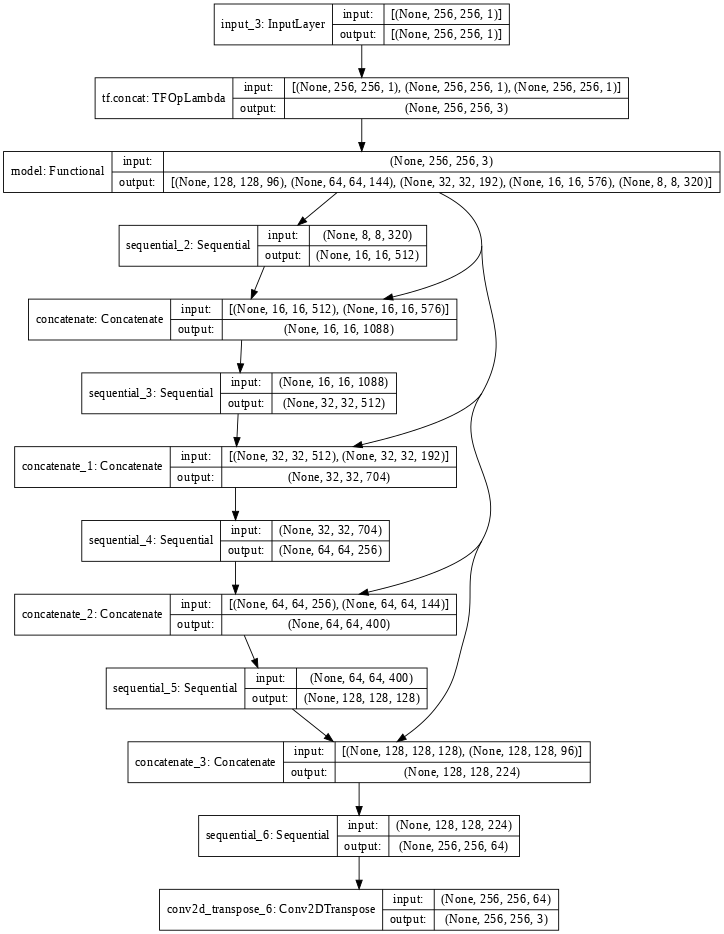

In [ ]:
generator.summary()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

#### Load Pix2pix-densenet generator

In [ ]:
save_path2 = '/content/drive/MyDrive/B.Tech Project/saved_models/pix2pix3/densenet121/bs1/'
generator2 = tf.keras.models.load_model(save_path2+'generator.h5')

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
tf.concat (TFOpLambda)          (None, 256, 256, 3)  0           input_3[0][0]                    
                                                                 input_3[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
model (Functional)              [(None, 128, 128, 64 7037504     tf.concat[0][0]                  
____________________________________________________________________________________________

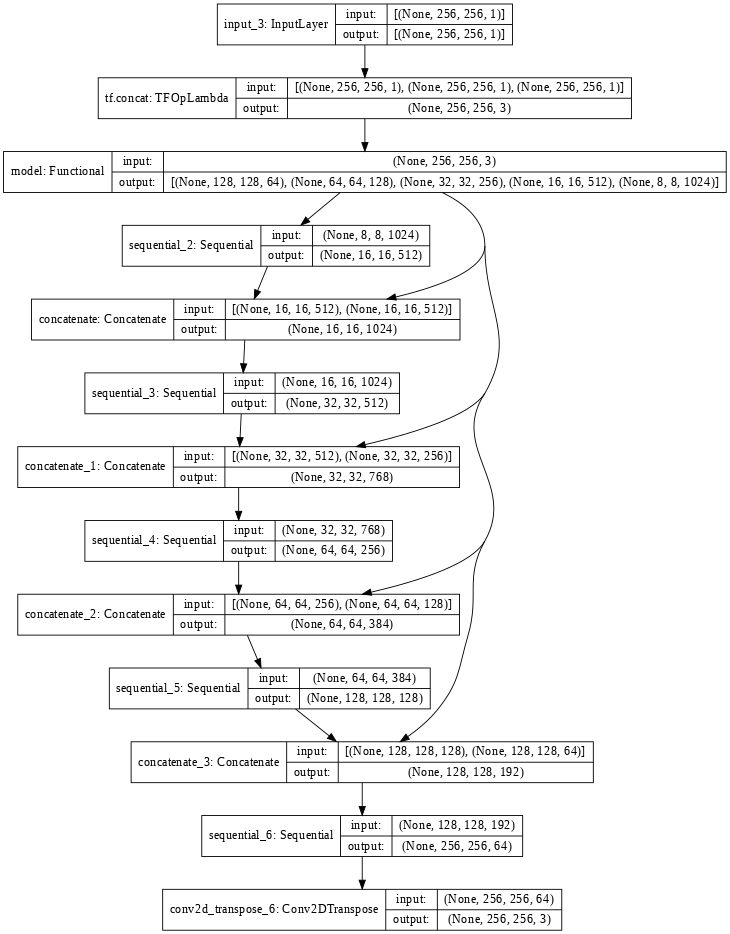

In [ ]:
generator2.summary()
tf.keras.utils.plot_model(generator2, show_shapes=True, dpi=64)

In [ ]:
for inp, tar in test_dataset.take(50):
  generate_images(generator2, inp, tar)

In [ ]:
discriminator = Discriminator()
discriminator.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
target_image (InputLayer)       [(None, 256, 256, 2) 0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 256, 256, 3)  0           input_image[0][0]                
                                                                 target_image[0][0]               
__________________________________________________________________________________________________
sequential (Sequential)         (None, 128, 128, 64) 3072        concatenate[0][0]            

#### Load CNN-based models

In [ ]:
model_cnn = tf.keras.models.load_model('/content/drive/MyDrive/B.Tech Project/saved_models/dataset_1/baseline_mse_finetune_50-0.010.h5')
model_incep = tf.keras.models.load_model('/content/drive/MyDrive/B.Tech Project/saved_models/dataset_1/incep_mse_finetune_20-0.00.h5')

In [ ]:
from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input

#Load weights
inception = tf.keras.applications.InceptionResNetV2(weights='imagenet', include_top=True)
# inception.load_weights('/content/drive/MyDrive/Btech_project/saved_models/inception_resnet_v2_weights_tf_dim_ordering_tf_kernels.h5')

#Create embedding
def create_inception_embedding(grayscaled_rgb):
    grayscaled_rgb_resized = []
    for i in grayscaled_rgb:
        i = transform.resize(i, (299, 299, 3), mode='constant')
        grayscaled_rgb_resized.append(i)
    grayscaled_rgb_resized = np.array(grayscaled_rgb_resized)
    grayscaled_rgb_resized = preprocess_input(grayscaled_rgb_resized)
    embed = inception.predict(grayscaled_rgb_resized)
    return embed

225214464/225209952 [==============================] - 2s 0us/step


### Calculate MSE, PSNR, SSIM

In [ ]:
mse_list=[]
psnr_list=[]
ssim_list=[]
inference_times = []

for i, (inp , tar) in enumerate(test_dataset):
    print(i+1)
    # print(inp.shape, tar.shape)
    
    # de-normalise input to 0-100
    output_cnn = model_cnn.predict((inp+1)*50)
    
    start = time.time()
    # de-normalise input to 0-255
    embed_inp = create_inception_embedding(np.expand_dims(gray2rgb(np.squeeze((inp+1)*127.5)), axis=0))
    # de-normalise input to 0-100
    output_incep = model_incep.predict([(inp+1)*50,embed_inp])
    end = time.time()
    inference_times.append(end-start)
    
    # for Lab image
    inp_l = tf.squeeze(inp[0])
    tar_rgb = to_rgb(inp[0],tar[0])
    pred_rgb_1 = to_rgb(inp[0],output_cnn[0])
    pred_rgb_2 = to_rgb(inp[0],output_incep[0])
    display_list = [inp_l, tar_rgb, pred_rgb_1, pred_rgb_2]

    metric_mse = tf.reduce_mean(tf.square(tar - output_incep)).numpy()
    metric_psnr = tf.image.psnr(tar, output_incep,max_val=2.0)[0].numpy()
    metric_ssim = tf.image.ssim(tar, output_incep, max_val=2.0)[0].numpy()

    mse_list.append(metric_mse)
    psnr_list.append(metric_psnr)
    ssim_list.append(metric_ssim)

    print('MSE:',metric_mse, 'PSNR:', metric_psnr, 'SSIM:', metric_ssim)
    # plt.figure(figsize=(15,15))
    # title = ['Input Image', 'Ground Truth', 'CNN', 'Inception-resnetv2']

    # for i in range(4):
    #     plt.subplot(1, 4, i+1)
    #     plt.title(title[i])
    #     # getting the pixel values between [0, 1] to plot it.
    #     plt.imshow(display_list[i] * 0.5 + 0.5,cmap='gray')
    #     plt.axis('off')
    # plt.show()

avg_mse = np.mean(mse_list)
avg_psnr = np.mean(psnr_list)
avg_ssim = np.mean(ssim_list)
print('Average values:')
print('MSE:',avg_mse, 'PSNR:', avg_psnr, 'SSIM:', avg_ssim)
print('Average inference time:',np.mean(inference_times))

In [ ]:
mse_list=[]
psnr_list=[]
# ssim_list=[]
inference_times = []

for i, (inp , tar) in enumerate(test_dataset):
    # print(i+1)
    # print(inp.shape, tar.shape)
    start = time.time()
    pred = generator2(inp, training=True)
    end = time.time()
    inference_times.append(end-start)
    # for Lab image
    inp_l = tf.squeeze(inp[0])
    tar_rgb = tar[0] #to_rgb(inp[0],tar[0])
    pred_rgb = pred[0] #to_rgb(inp[0],pred[0])
    display_list = [inp_l, tar_rgb, pred_rgb]

    metric_mse = tf.reduce_mean(tf.square(tar - pred)).numpy()
    metric_psnr = tf.image.psnr(tar, pred,max_val=2.0)[0].numpy()
    metric_ssim = tf.image.ssim(tar, pred, max_val=2.0)[0].numpy()

    mse_list.append(metric_mse)
    psnr_list.append(metric_psnr)
    # ssim_list.append(metric_ssim)

    # print('MSE:',metric_mse, 'PSNR:', metric_psnr, 'SSIM:', metric_ssim)
    # plt.figure(figsize=(20,15))
    # title = ['Input Image', 'Ground Truth', 'Predicted Image']

    # for i in range(3):
    #     plt.subplot(1, 3, i+1)
    #     plt.title(title[i])
    #     # getting the pixel values between [0, 1] to plot it.
    #     plt.imshow(display_list[i] * 0.5 + 0.5,cmap='gray')
    #     plt.axis('off')
    # plt.show()

avg_mse = np.mean(mse_list)
avg_psnr = np.mean(psnr_list)
# avg_ssim = np.mean(ssim_list)
print('Average values:')
print('MSE:',avg_mse, 'PSNR:', avg_psnr)
print('Average inference time:',np.mean(inference_times))

Average values:
MSE: 0.023703694 PSNR: 23.725328
Average inference time: 0.10286539465146946


sem7_test

For RGB images:(with spot) 

        Densenet121 mse error: 0.0234
        Average values:
        MSE: 0.0237 PSNR: 23.725
        Average inference time: 0.103

        MobilenetV2 mse error: 0.0291
        Average values:
        MSE: 0.0289 PSNR: 22.59
        Average inference time: 0.053

For Lab images:

- Average values: baseline CNN
        MSE: 0.012060764 PSNR: 26.443317
        Average inference time: 0.056530563047809894

- Average values: Inception-resnetv2
        MSE: 0.012103569 PSNR: 26.630455
        Average inference time: 0.15866528243372907
- Average values: Mobilenetv2

        MSE: 0.010663359 PSNR: 26.870356
        Average inference time: 0.06132557899894768

- Average values: Densenet121

        MSE: 0.010835831 PSNR: 26.872643
        Average inference time: 0.11661153956091791



In [ ]:
8fig = plt.figure(figsize=(15,30))
grid = ImageGrid(fig, 111,  
                 nrows_ncols=(8, 6), 
                 axes_pad=0.0, 
                 )

for i, (inp , tar) in enumerate(test_dataset.shuffle(500).take(48)):
    if(i%8==0 and i!=0):
        plt.show()
        fig = plt.figure(figsize=(15,30))
        grid = ImageGrid(fig, 111,  
                        nrows_ncols=(8, 6), 
                        axes_pad=0.0, 
                        )
    
    # mobilenet output
    pred_mob = generator(inp, training=False)
    # densenet output
    pred_dense = generator2(inp, training=False)

    # baseline CNN output, de-normalise input to 0-100
    pred_cnn = model_cnn.predict((inp+1)*50)
    # de-normalise input to 0-255
    embed_inp = create_inception_embedding(np.expand_dims(gray2rgb(np.squeeze((inp+1)*127.5)), axis=0))
    # Inception-resnetv2 based CNN, de-normalise input to 0-100
    pred_incep = model_incep.predict([(inp+1)*50,embed_inp])

    
    # for Lab image
    inp_l = tf.squeeze(inp[0])
    tar_rgb = to_rgb(inp[0],tar[0])
    pred_mob = to_rgb(inp[0],pred_mob[0])
    pred_dense = to_rgb(inp[0],pred_dense[0])
    pred_cnn = to_rgb(inp[0],pred_cnn[0])
    pred_incep = to_rgb(inp[0],pred_incep[0])
    # Input image, Baseline CNN, Inception-resnetv2 based CNN, Pix2pix with mobilenetv2 encoder, Pix2pix with densenet121 encoder, Target image
    display_list = [inp_l, pred_cnn, pred_incep, pred_mob, pred_dense, tar_rgb]


    for j in range(6):
        grid[(i%8)*6 + j].imshow(display_list[j] * 0.5 + 0.5,cmap='gray')
        grid[(i%8)*6 + j].axis('off')


Output hidden; open in https://colab.research.google.com to view.